In [17]:
import torch
import cv2 as cv
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
# case can have to be mix of this two groops (rgb, dept, Ergbd, Lrgbd) and (rad, angle)

case = 'Lrgbd_angle'
ver = 4

In [19]:
class LateFusionNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(LateFusionNet, self).__init__()
        # Separate convolutional layers for RGB and depth streams
        self.conv_rgb = torchvision.models.resnet18(pretrained=False)
        self.conv_rgb.fc = torch.nn.Identity()
        
        self.conv_depth = torchvision.models.resnet18(pretrained=False)
        self.conv_depth.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv_depth.fc = torch.nn.Identity()
        
        # Fully connected layers for fusion
        self.fc1 = torch.nn.Linear(512 * 2, 128)  # Concatenating features from both streams
        self.fc2 = torch.nn.Linear(128, num_classes)  # Adjust num_classes based on your task
        
    def forward(self, rgbd_inputs):
        rgb_inputs = rgbd_inputs[:,:3,:,:]
        depth_inputs = rgbd_inputs[:,3,:,:].unsqueeze(1)

        # Forward pass for RGB stream
        rgb_features = self.conv_rgb(rgb_inputs)
        # Forward pass for depth stream
        depth_features = self.conv_depth(depth_inputs)
        
        # Concatenate features from both streams
        combined_features = torch.cat((rgb_features, depth_features), dim=1)
        
        # Fully connected layers for fusion
        x = self.fc1(combined_features)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [20]:
if case.split('_')[1] == 'angle':
    classes = 16
    
elif case.split('_')[1] == 'rad':
    classes = 6

rgb_img_dir = './dataset/test/rgb/'
depth_img_dir = './dataset/test/depth/'

weights = './Weights/' + case + '_v' + str(ver) + '.pth'
csv_path = './dataset/test/test_data.csv'

In [21]:
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, classes)

if case.split('_')[0] == 'depth':
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# elif case.split('_')[0] == 'rgb':
  # model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
elif case.split('_')[0] == 'Ergbd':
    model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

elif case.split('_')[0] == 'Lrgbd':
    model = LateFusionNet(classes)
    
model.eval()
model.load_state_dict(torch.load(weights)) # Load weights
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

LateFusionNet(
  (conv_rgb): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [22]:
def im2tens(rgb, depth, case):
        
        rgb_transform = torchvision.transforms.ToTensor()
        depth_transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
                 
        rgb_tensor = rgb_transform(rgb)
        depth_tensor = depth_transform(depth)

        rgbd_tensor = torch.cat([rgb_tensor, depth_tensor], dim=0)
        
        if case.split('_')[0] == 'rgb':
                img_tensor = rgb_tensor
                
        elif case.split('_')[0] == 'depth':
                img_tensor = depth_tensor
        else:
                img_tensor = rgbd_tensor

        return img_tensor

# Pregict class.
def predict(img, model, device):
    
    xb = img.unsqueeze(0)
    yb = model(xb.to(device))
    # Get the normalized probability vector
    p = torch.nn.functional.softmax(yb, dim=1)
    dist = p[0].cpu().detach().numpy()
    
    return dist

In [23]:
# Calculates an average between the predicted vector and the values of the angles of the middle of the slices.
def avg_pred(pred, case, th=1):
    
    if case.split('_')[1] == 'rad':
        
        if th == 1:
            th = 0.05
            
        pred = np.where(pred < th, 0, pred)
        pred = pred/np.sum(pred)
        step = np.linspace(0, 6, 6)
        avg_pred = np.dot(step, pred) 
    
    elif case.split('_')[1] == 'angle':

        if th == 1: 
            th = 00.1
            
        pred = np.where(pred < th, 0, pred)
        pred = pred/np.sum(pred)
        step = 2*np.pi / len(pred)
        mid_slice = [step/2 + step * interval for interval in range(len(pred))]

        sin = np.zeros((len(mid_slice)))
        cos = np.zeros((len(mid_slice)))
        for ii in range(len(mid_slice)):
            sin[ii] = np.sin(mid_slice[ii])
            cos[ii] = np.cos(mid_slice[ii])
            
        dot_sin = np.dot(sin, pred)
        dot_cos = np.dot(cos, pred)
        tan = np.arctan2(dot_sin ,dot_cos)
        avg_pred = np.rad2deg(tan)
        if avg_pred < 0: avg_pred = avg_pred+360

    else:
            print ('error "case" not defined')        
        

    return avg_pred

In [24]:
def plot_graph(gts, preds, case):
    
    if case.split('_')[1] == 'rad':
        
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title('Real rad vs predict rad')
        ax.set_ylabel('Predict rad')
        ax.set_xlabel('Real rad')
        ax.axis([0, 6, 0, 6])
        ax.set_aspect('equal')
        ax.grid()
        
        ax.scatter(gts, preds, color='k')
        x = np.linspace(0,6)
        ax.plot(x, x, 'r')
        ax.legend(('pred', 'gt'))
        plt.show()
        
    elif case.split('_')[1] == 'angle':
        
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title('Real angle vs predict angle')
        ax.set_ylabel('Predict angle')
        ax.set_xlabel('Real angle')
        ax.axis([0, 400, 0, 400])
        ax.set_aspect('equal')
        ax.grid()
        
        ax.scatter(gts, preds, color='k')
        x = np.linspace(0,360)
        ax.plot(x, x, 'r')
        ax.legend(('pred', 'gt'))
        plt.show()


In [25]:
def main_pred(rgb, depth, model, device, case):
    
    img_tensor = im2tens(rgb, depth, case)
    dist = predict(img_tensor, model, device)
    preds = avg_pred(dist, case)
    
    return preds

In [26]:
df = pd.read_csv(csv_path)
im_name = df.loc[:, 'Picture name']
angle = df.loc[:, 'Angle [deg]']
rad = df.loc[:, 'Radial distance [mm]']

gts = []
preds = []

for ii in range(len(im_name)):
    
    rgb = cv.cvtColor(cv.imread(rgb_img_dir + im_name[ii]), cv.COLOR_BGR2RGB)
    depth = cv.cvtColor(cv.imread(depth_img_dir + im_name[ii]), cv.COLOR_BGR2RGB)

    pred = main_pred(rgb, depth, model, device, case)
   
    if case.split('_')[1] == 'rad':
        gt = rad[ii]

    elif case.split('_')[1] == 'angle':
        gt = angle[ii]
        
        if np.abs(pred - gt) > 180:
            pred = 360 - pred
            
    gts.append(gt)
    preds.append(pred) 

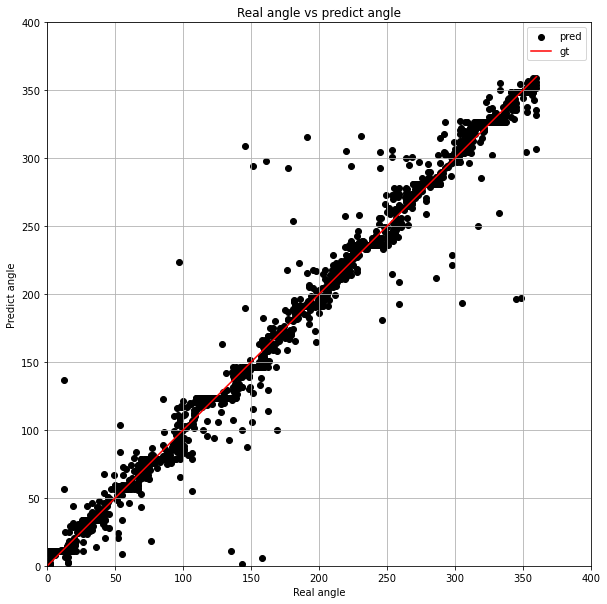

In [27]:
plot_graph(gts, preds, case)